# notebook minist and different optimizers

the basis is kaiminig optimization and batchnorm

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
from torch import *

#let me be on my mac
def cuda(self, device=None, non_blocking=False) : return self
torch.Tensor.cuda = cuda

In [3]:
from lib.callbacks import *
from lib.model import *
from lib.data import *
from lib.optimizers import *
from pathlib import Path

## mnist data

In [4]:
x_train,y_train,x_valid,y_valid = get_mnist_data(Path("/Users/kasparlund/.fastai/data/mnist.pkl.gz"))
x_train,x_valid   = normalize_to(x_train,x_valid)

x_train.mean(),x_train.std()

(tensor(-7.6999e-06), tensor(1.))

In [5]:
nh,bs              = 50,512
train_ds,valid_ds  = Dataset(x_train, y_train),Dataset(x_valid, y_valid)
train_dl, valid_dl = ( DataLoader( train_ds, batch_size=bs, shuffle=True), 
                        DataLoader(valid_ds,  batch_size=bs*2) )
data               = DataBunch( train_dl, valid_dl, c_in=1, c_out=y_train.max().item()+1 )
print(len(train_dl)), print(len(valid_dl))

98
10


(None, None)

In [6]:
mnist_view   = view_tfm(1,28,28)
layers_sizes = [8,16,32,32]
loss_func    = F.cross_entropy
sched        = combine_scheds([0.3, 0.7], [sched_cos(0.3, 0.6), sched_cos(0.6, 0.2)]) 
cbfs         = [TrainableModelCallback, TrainEvalCallback, OptimizerCallback, 
#                partial(ParamScheduler, 'lr', sched),
                partial(BatchTransformXCallback, tfm = mnist_view), 
#                LR_Finder,
                Recorder, 
                partial(AvgStatsCallback,[accuracy]),
                ProgressCallback]


## steppers=[sgd_step]

In [9]:
model = get_cnn_model(layers_sizes, data.c_in, data.c_out, conv_layer )
init_cnn( model )
opt = SGD(sched,max_lr=0.5)
learn = Learner( model, data, loss_func=F.cross_entropy, opt=opt, cb_funcs=cbfs)
%time learn.fit(1)

epoch,train_loss,train_accuracy,valid_loss,valid_accuracy,time
0,1.096989,0.686660,0.350056,0.921600,00:05


CPU times: user 27.9 s, sys: 5.93 s, total: 33.8 s
Wall time: 5.11 s


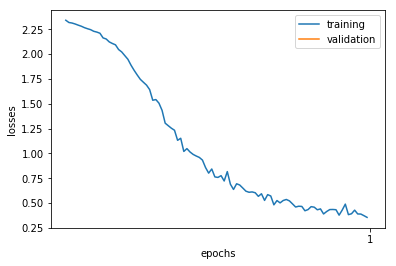

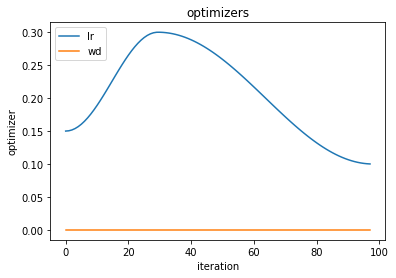

(None, None)

In [10]:
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()

## steppers=[weight_decay, sgd_step]

In [ ]:
model = get_cnn_model(layers_sizes, data.c_in, data.c_out, conv_layer )
init_cnn( model )
opt = SGD(sched,max_lr=0.5, max_wd=0.01)
#print(opt.hypers[0]['lr']), print(opt.hypers[0]['wd'])
learn = Learner( model, data, loss_func=F.cross_entropy, opt=opt,cb_funcs=cbfs)
%time learn.fit(1)

In [ ]:
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()

## momentum: steppers=[momentum_step,weight_decay]

In [ ]:
model = get_cnn_model(layers_sizes, data.c_in, data.c_out, conv_layer )
init_cnn( model )        
opt   = SGD_Momentum(sched,max_lr=0.4, moms=(0.85,0.95), max_wd=1e-3 )
learn = Learner( model, data, loss_func=F.cross_entropy, opt=opt, cb_funcs=cbfs)
%time learn.fit(1)

In [ ]:
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()

## Adam: steppers=[adam_step]

In [ ]:
model = get_cnn_model(layers_sizes, data.c_in, data.c_out, conv_layer )
init_cnn( model )
opt   = Adam(sched,max_lr=0.05, moms=(0.85,0.95), max_wd = 1e-3)
learn = Learner( model, data, loss_func=F.cross_entropy, opt=opt, cb_funcs=cbfs)
%time learn.fit(4)

In [ ]:
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()

## LAMB: steppers=[lamb_step]

It's then super easy to implement a new optimizer. This is LAMB from a [very recent paper](https://arxiv.org/pdf/1904.00962.pdf):

$\begin{align}
g_{t}^{l} &= \nabla L(w_{t-1}^{l}, x_{t}) \\
m_{t}^{l} &= \beta_{1} m_{t-1}^{l} + (1-\beta_{1}) g_{t}^{l} \\
v_{t}^{l} &= \beta_{2} v_{t-1}^{l} + (1-\beta_{2}) g_{t}^{l} \odot g_{t}^{l} \\
m_{t}^{l} &= m_{t}^{l} / (1 - \beta_{1}^{t}) \\
v_{t}^{l} &= v_{t}^{l} / (1 - \beta_{2}^{t}) \\
r_{1} &= \|w_{t-1}^{l}\|_{2} \\
s_{t}^{l} &= \frac{m_{t}^{l}}{\sqrt{v_{t}^{l} + \epsilon}} + \lambda w_{t-1}^{l} \\ 
r_{2} &= \| s_{t}^{l} \|_{2} \\
\eta^{l} &= \eta * r_{1}/r_{2} \\ 
w_{t}^{l} &= w_{t}^{l-1} - \eta_{l} * s_{t}^{l} \\
\end{align}$

In [ ]:
model = get_cnn_model(layers_sizes, data.c_in, data.c_out, conv_layer )
init_cnn( model )            
opt   = LAMB(sched,max_lr=0.02, moms=(0.85,0.95), max_wd = 1e-6)     
learn = Learner( model, data, loss_func=F.cross_entropy, opt=opt, cb_funcs=cbfs)
%time learn.fit(1)

In [ ]:
learn.find_subcription_by_cls(Recorder).plot_lr(),plt.show()
learn.find_subcription_by_cls(Recorder).plot_loss(),plt.show()

## mnist with adam and hooks

In [ ]:
model = get_cnn_model(layers_sizes, data.c_in, data.c_out, conv_layer )
init_cnn( model )
opt   = Adam(sched,max_lr=0.05, moms=(0.85,0.95), max_wd = 1e-3)
learn = Learner( model, data, loss_func=F.cross_entropy, opt=opt, cb_funcs=cbfs)
with Hooks(model, append_stats) as hooks: 
    learn.fit(1)
    plot_layer_stats( hooks )

## mnist with LAMB and hooks

In [ ]:
model = get_cnn_model(layers_sizes, data.c_in, data.c_out, conv_layer )
init_cnn( model )
opt   = LAMB(sched,max_lr=0.008, moms=(0.85,0.95), max_wd = 1e-6)     
learn = Learner( model, data, loss_func=F.cross_entropy, opt=opt, cb_funcs=cbfs)
with Hooks(model, append_stats) as hooks: 
    learn.fit(1)
    plot_layer_stats( hooks )